In [173]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
import scipy.stats as stats
from scipy.special import expit
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import (r2_score, mean_absolute_error, mean_squared_error, 
                             mean_absolute_percentage_error, root_mean_squared_error)
from sklearn.inspection import permutation_importance
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.layers import Normalization

In [180]:
df = pd.read_csv(r"C:\Users\Robyi\Documents\Data Science Dataset\delivery.csv")
df = df.drop(columns=df[['Order_ID','Weather', 'Traffic_Level','Time_of_Day', 'Vehicle_Type']])
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.head()

,Distance_km,Preparation_Time_min,Courier_Experience_yrs,Delivery_Time_min
0,7.93,12,1.0,43
1,16.42,20,2.0,84
2,9.52,28,1.0,59
3,7.44,5,1.0,37
4,19.03,16,5.0,68


In [181]:
x = df.drop(columns=['Delivery_Time_min']).values
y = df['Delivery_Time_min'].values

In [184]:
x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.2, random_state=42)

In [185]:
normalizer = Normalization(axis=-1)
normalizer.adapt(x_train)
x_train_adapt = normalizer(x_train)
x_test_adapt = normalizer(x_test)

In [ ]:
def model_build(hp):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Input(shape = (x_train_adapt.shape[1],)))

    for i in range(hp.Int('num_layers', 1, 3)):
        model.add(tf.keras.layers.Dense(units=hp.Int(f'units_{i}',
                                                     min_value = 16, max_value = 256, step = 8),
                                                     activation=hp.Choice('activation',['relu','tanh'])
                                                     ))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dropout(rate=hp.Float(f'dropout_rate_{i}',
                                                         min_value=0.1, max_value=0.5, step=0.1)))
    model.add(tf.keras.layers.Dense(1, activation='linear'))
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=hp.Choice(
                'lr',[0.01, 0.001])), loss='mse',metrics=[
                    'mae'])
    return model

In [ ]:
tuner = kt.Hyperband(
    model_build,
    objective='val_mae',
    max_epochs = 50,
    factor=3,
    directory = 'keras_tuner_result',
    project_name='delivery_mlpr'
)

Reloading Tuner from keras_tuner_result\delivery_mlpr\tuner0.json


In [197]:
tuner.search(x_train_adapt, y_train,
             validation_split=0.2, epochs = 50,
             batch_size = 16, verbose=True)

Trial 80 Complete [00h 00m 27s]
val_mae: 8.684855461120605

Best val_mae So Far: 8.352899551391602
Total elapsed time: 01h 39m 21s


In [198]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

In [199]:
best_model = tuner.hypermodel.build(best_hps)

In [201]:
history = best_model.fit(x_train_adapt, y_train,
                         validation_split=0.2,
                         epochs=50,
                         batch_size=16,
                         verbose=True)

Epoch 1/50


39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 3205.6646 - mae: 53.0836 - val_loss: 1000.7260 - val_mae: 28.4383
Epoch 2/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 422.3370 - mae: 16.1325 - val_loss: 203.2907 - val_mae: 9.6969
Epoch 3/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 140.8280 - mae: 8.4142 - val_loss: 194.4696 - val_mae: 8.4015
Epoch 4/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 141.4962 - mae: 8.0157 - val_loss: 193.2548 - val_mae: 8.4324
Epoch 5/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 171.2487 - mae: 8.7606 - val_loss: 199.7342 - val_mae: 8.6493
Epoch 6/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 155.1488 - mae: 8.1289 - val_loss: 194.0623 - val_mae: 8.3431
Epoch 7/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 116.0947 - mae: 7.5798 - val_loss: 195.0304 - val_mae: 8.6494
Epoch 8/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 157.8290 - mae: 8.2702 - val_loss: 201.5135 - val_mae: 8.5471
Epoch 9/50
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 7

In [204]:
y_pred = best_model.predict(x_test_adapt)
proba = expit(y_pred)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [205]:
print(proba)
print(y_pred)

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.

In [206]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = root_mean_squared_error(y_test,y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

n = len(y_test)
p = x_test.shape[1]
r2_adj = 1 - ((1-r2) * (n - 1) / (n - p - 1))

print(mse)
print(mae)
print(rmse)
print(mape)
print(r2)
print(r2_adj)

124.87850982753837
7.868353489747982
11.174905361010373
0.14974458957053888
0.7521559000015259
0.7482425721068131


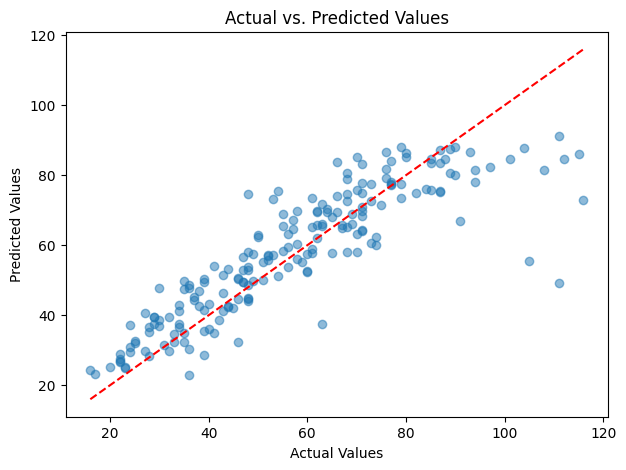

In [207]:
plt.figure(figsize=(7, 5))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--') 
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs. Predicted Values")
plt.show()

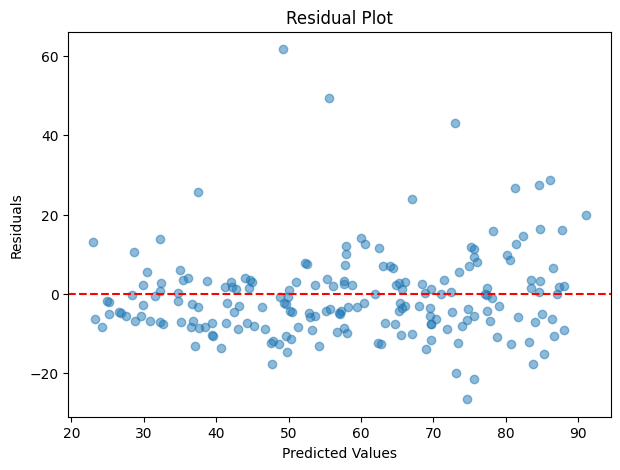

In [210]:
y_predict = np.array(y_pred).flatten() 
residuals = y_test - y_predict

plt.figure(figsize=(7, 5))
plt.scatter(y_predict, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel("Predicted Values")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.show()

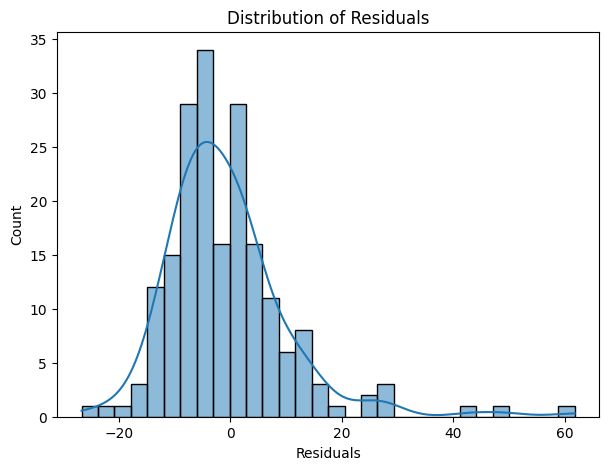

In [211]:
plt.figure(figsize=(7, 5))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("Residuals")
plt.title("Distribution of Residuals")
plt.show()

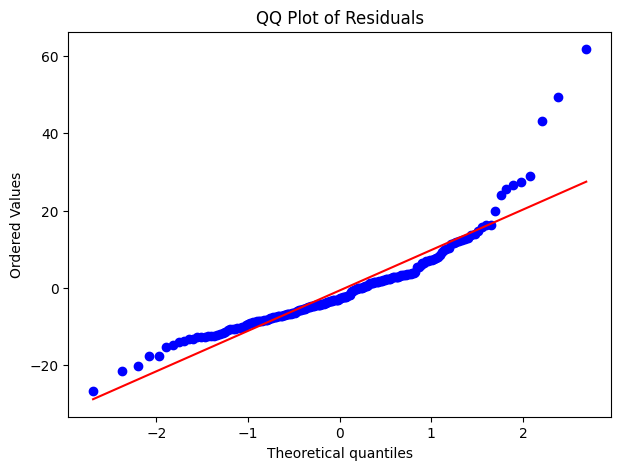

In [212]:
plt.figure(figsize=(7, 5))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("QQ Plot of Residuals")
plt.show()

In [ ]:
print("\nModel Evaluation:")
results = best_model.evaluate(x_test_adapt, y_test, verbose=0)
metrics = dict(zip(best_model.metrics_names, results))
for name, value in metrics.items():
    print(f"{name}: {value:.4f}")


Model Evaluation:
loss: 124.8785
compile_metrics: 7.8684


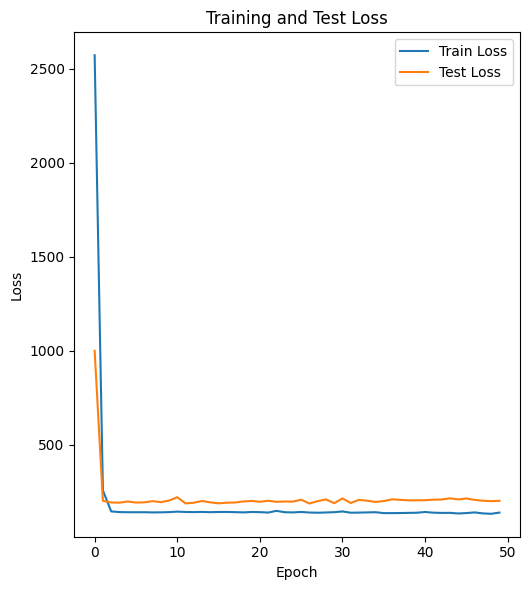

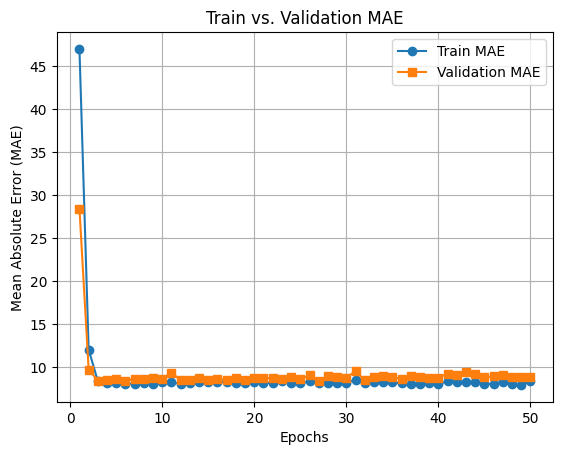

In [224]:
train_loss = history.history['loss']
test_loss = history.history['val_loss'] 
train_mae = history.history['mae']  
val_mae = history.history['val_mae'] 
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(10,6))
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.title('Training and Test Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.tight_layout()
plt.show()

plt.plot(epochs, train_mae, label='Train MAE', marker='o')
plt.plot(epochs, val_mae, label='Validation MAE', marker='s')
plt.xlabel("Epochs")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Train vs. Validation MAE")
plt.legend()
plt.grid()
plt.show()

In [229]:
print("\nAdvanced Metrics:")
print(f"- Maximum Training Accuracy: {max(train_loss):.4f}")
print(f"- Minimum Test Loss: {min(test_loss):.4f}")
print(f"- Optimal Epochs: {len(train_loss)}")
print(f"- Maximum Training MAE: {max(train_mae):.4f}")
print(f"- Test MAE: {max(val_mae):.4f}")


Advanced Metrics:
- Maximum Training Accuracy: 2571.5913
- Minimum Test Loss: 188.8700
- Optimal Epochs: 50
- Maximum Training MAE: 47.0459
- Test MAE: 28.4383


Feature 0: 0.1908867508172989
Feature 1: 0.1633027344942093
Feature 2: 0.12902207672595978


C:\Users\Robyi\AppData\Local\Temp\ipykernel_14872\2041223268.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance, y=feature_names, orient="h", palette="viridis")


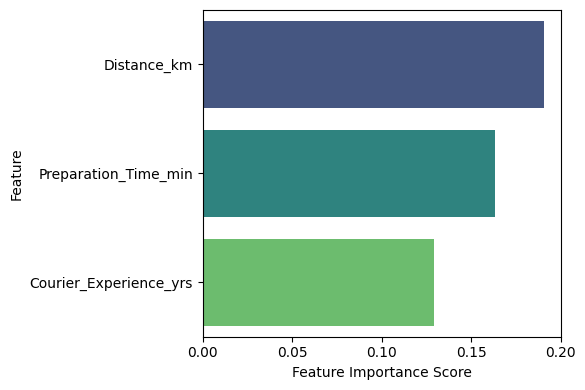

In [216]:
weights = best_model.layers[0].get_weights()[0]

feature_importance = np.mean(np.abs(weights), axis=1)
column = df.drop(columns=['Delivery_Time_min'])
feature_names = column.columns

for i, importance in enumerate(feature_importance):
    print(f"Feature {i}: {importance}")

plt.figure(figsize=(6, 4))
sns.barplot(x=feature_importance, y=feature_names, orient="h", palette="viridis")
plt.xlabel("Feature Importance Score")
plt.ylabel("Feature")
plt.tight_layout()

In [217]:
best_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                 │ (None, 176)            │           704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           177 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,645 (10.34 KB)

 Trainable params: 881 (3.44 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,764 (6.89 KB)

In [218]:
explainer = shap.Explainer(best_model, x_train)

if hasattr(x_test_adapt, 'numpy'):
    x_test_adapt = x_test_adapt.numpy()
shap_values = explainer(x_test_adapt)

ExactExplainer explainer: 195it [00:13, 12.36it/s]                         


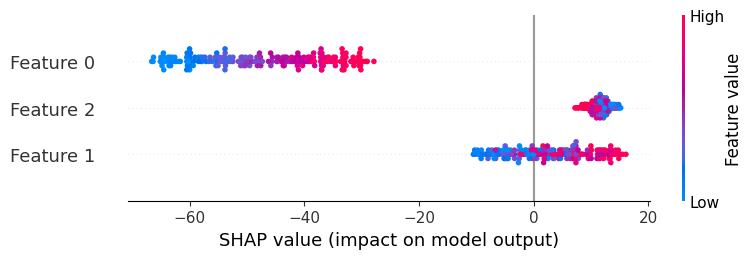

In [219]:
shap.summary_plot(shap_values.values, x_test_adapt)

In [ ]:
prediksi = pd.read_csv(r"C:\Users\Robyi\Documents\Data Science Dataset\deliverypredict.csv")
prediksi.head()

In [ ]:
y_prediksi = best_model.predict(prediksi)
probabilitas_prediksi = expit(y_prediksi)
print(y_prediksi)
print(probabilitas_prediksi)